# Install Torch

In [1]:
torchver = "0.4.0"

In [2]:
!/opt/bin/nvidia-smi || /usr/bin/nvidia-smi

/bin/sh: 1: /opt/bin/nvidia-smi: not found
Mon May 28 13:07:24 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.25                 Driver Version: 390.25                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 980     Off  | 00000000:01:00.0  On |                  N/A |
|  0%   54C    P8    15W / 185W |    352MiB /  4038MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                 

In [3]:
!ls /colabtools

ls: cannot access '/colabtools': No such file or directory


In [4]:
!python --version

Python 3.6.5 :: Anaconda, Inc.


In [5]:
!pip3 uninstall -y pillow
!CC="cc -mavx2" pip3 install -U --force-reinstall pillow-simd


Uninstalling Pillow-5.1.0:
  Successfully uninstalled Pillow-5.1.0
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
scikit-image 0.13.0 requires pillow>=2.1.0, which is not installed.
torchvision 0.2.0 requires pillow>=4.1.1, which is not installed.
django-haystack 2.8.1 has requirement Django>=1.11, but you'll have django 1.7.11 which is incompatible.
  Found existing installation: Pillow-SIMD 5.1.1.post0
    Uninstalling Pillow-SIMD-5.1.1.post0:
      Successfully uninstalled Pillow-SIMD-5.1.1.post0


In [6]:

!pip3 install ipdb


tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
scikit-image 0.13.0 requires pillow>=2.1.0, which is not installed.
torchvision 0.2.0 requires pillow>=4.1.1, which is not installed.
django-haystack 2.8.1 has requirement Django>=1.11, but you'll have django 1.7.11 which is incompatible.


In [7]:

from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

pver = !python --version |& awk '{print $2 }' | awk -F. '{ print $1$2}'
pyver = pver[0]
print(pyver)

# cver = !echo "cu`nvcc --version | sed "s/ /\n/g" | grep -i release -A 1 | tail -n 1 | tr -d [\.,]`"
# cudaver = cver[0]
cudaver = 'cu91'

accelerator =  cudaver if path.exists('/opt/bin/nvidia-smi') or path.exists('/usr/bin/nvidia-smi') else 'cpu'
print(accelerator)

torchurl = "http://download.pytorch.org/whl/{0}/torch-{1}-cp{2}-cp{2}m-linux_x86_64.whl".format(accelerator, torchver, pyver)
print(torchurl)

!pip3 install http://download.pytorch.org/whl/cu91/torch-0.4.0-cp36-cp36m-linux_x86_64.whl 
!pip3 install torchvision

import torch
import torchvision
print(torchvision.get_image_backend())

36
cu91
http://download.pytorch.org/whl/cu91/torch-0.4.0-cp36-cp36m-linux_x86_64.whl
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
scikit-image 0.13.0 requires pillow>=2.1.0, which is not installed.
torchvision 0.2.0 requires pillow>=4.1.1, which is not installed.
django-haystack 2.8.1 has requirement Django>=1.11, but you'll have django 1.7.11 which is incompatible.
  Using cached https://files.pythonhosted.org/packages/5f/4b/8b54ab9d37b93998c81b364557dff9f61972c0f650efa0ceaf470b392740/Pillow-5.1.0-cp36-cp36m-manylinux1_x86_64.whl
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
django-haystack 2.8.1 has requirement Django>=1.11, but you'll have django 1.7.11 which is incompatible.
PIL


In [8]:
!pip3 install tqdm

tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
django-haystack 2.8.1 has requirement Django>=1.11, but you'll have django 1.7.11 which is incompatible.


# Imports

In [9]:
import torch
import os
import sys
import logging
import io
import time
import shutil
from tqdm import tqdm
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from argparse import Namespace
from collections import OrderedDict
from scipy.sparse import coo_matrix
import socket
from datetime import datetime
import json
import re

In [10]:
%matplotlib inline

# Parameters

In [11]:
def get_hostname_timestamp_id():
    return socket.gethostname() + '_' + re.sub(r'\W+', '', str(datetime.now()))

In [12]:
def get_output_fname():
    return "%s_%s_%s" % (args.author, args.arch, get_hostname_timestamp_id())

In [13]:
args = Namespace()
# base_dir = '/content/fashion'
args.base_dir = '/data/datasets/kaggle_fashion'
args.data_dir = args.base_dir + os.sep + 'data'
args.input_dir = args.data_dir + os.sep + 'input'
args.output_dir = args.data_dir + os.sep + 'output'
args.train_zip = args.input_dir + os.sep + 'train_data.zip'
args.val_zip = args.input_dir + os.sep + 'validation_data.zip'
args.train_dir = args.input_dir + os.sep + 'img_train'
args.val_dir = args.input_dir + os.sep + 'img_val'
args.test_dir = args.input_dir + os.sep + 'img_test'
args.train_id = "1rx1rL8RUAggN4hKlrYLtpdQagtUWmIbO"
args.val_id = "1U19eWiBFJ6wGcFk47l6g9mmoWp1i4hPY"
# args.train_labels_id = "1NOoWniR3ioqPKbVWoaWGy4HPDzZAAJX9"
args.train_labels_id = "1X7TpWyxxtmCT5rw__7OKus_W4fh8xpKO" # small dataset
args.val_labels_id = "1d9RuQTx5E8qFxraIu6B4rDTOC4sx2xXT"
args.test_labels_id = "1VwzGCJfOL13pk1Wi-xPHQ6mVnofy9_Z4"
# args.train_labels_json = args.input_dir + os.sep + 'train.json'
args.train_labels_json = args.input_dir + os.sep + 'train_small.json' 
# args.train_labels_json = args.input_dir + os.sep + 'train_tiny.json' 
args.val_labels_json = args.input_dir + os.sep + 'validation.json'
args.test_labels_json = args.input_dir + os.sep + 'test.json'
args.debug_weights = False
args.test_overfit = False
args.num_labels = 228
args.batch_size = 16
args.image_min_size = 256
args.nw_input_size = 224
args.num_workers = 4
args.imagenet_mean = [0.485, 0.456, 0.406]
args.imagenet_std = [0.229, 0.224, 0.225]
args.pretrain_dset_mean = args.imagenet_mean
args.pretrain_dset_std = args.imagenet_std
args.world_size = 1
args.dist_url = 'file://' + args.output_dir + os.sep + 'dfile'
args.dist_backend = 'gloo'
args.distributed = args.world_size > 1
args.arch = 'resnet101'
args.fv_size = 2048
args.pretrained = True
args.resume = False
args.start_epoch = 0
args.small=1e-12                         # small value used for avoiding div by zero
args.optimizer_learning_rate = 1e-4      # Adam optimizer initial learning rate
args.scheduler_patience = 1              # Number of epochs with no improvement after which learning rate will be reduced
args.scheduler_threshold = 1e-6          # learning rate scheduler threshold for measuring the new optimum, to only focus on significant changes
args.scheduler_factor = 0.1        # learning rate scheduler factor by which the learning rate will be reduced. new_lr = lr * factor
args.earlystopping_patience = 1          # early stopping patience is the number of epochs with no improvement after which training will be stopped
args.earlystopping_min_delta = 1e-5      # minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement
args.evaluate = False
args.epochs = 20
args.print_freq = args.batch_size
args.ckpt_dir = args.output_dir + os.sep + 'ckpt'
args.ckpt = args.ckpt_dir + os.sep + 'ckpt_%s.pth.tar' % (args.arch,)
args.best = args.ckpt_dir + os.sep + 'best_%s.pth.tar' % (args.arch,)
args.threshold = 0.5
args.sub_dir = args.output_dir + os.sep + 'submissions'
args.author = 'deccanlearners'
args.output_id = get_output_fname()
args.output_file = args.sub_dir + os.sep + 'output_%s.csv' %  args.output_id
args.params_file = args.sub_dir + os.sep + 'params_%s.json' % args.output_id
args.min_img_bytes = 4792

In [14]:
print(torch.backends.cudnn.version())
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


7102
True
GeForce GTX 980


In [15]:
cudnn.benchmark = True

In [16]:
os.makedirs(args.base_dir, exist_ok=True)
os.makedirs(args.data_dir, exist_ok=True)
os.makedirs(args.input_dir, exist_ok=True)
os.makedirs(args.output_dir, exist_ok=True)
os.makedirs(args.ckpt_dir, exist_ok=True)
os.makedirs(args.sub_dir, exist_ok=True)

# Download Dataset

In [17]:
# from google.colab import auth
# auth.authenticate_user()

In [18]:
# from googleapiclient.discovery import build
# import io
# from googleapiclient.http import MediaIoBaseDownload
# import json

# def md5_hash(fname, blocksize=4096):
#     """ compute md5hash of a file """
#     import hashlib
#     hash = ''
#     if not os.path.exists(fname):
#         errmsg = "File %s does not exist" % (fname)
#         print(errmsg)
#         return ''
#     try:
#         hasher = hashlib.md5()
#         with open(fname, 'rb') as f:
#             buf = f.read(blocksize)
#             while len(buf) > 0:
#                 hasher.update(buf)
#                 buf = f.read(blocksize)
#         hash = hasher.hexdigest()
#     except:
#         print("Exception in hashing file")
#         raise
#     return hash

# def _download(drive_service, file_id, loc):
#   request = drive_service.files().get_media(fileId=file_id)
#   fh = io.FileIO(loc, mode='wb')
#   downloader = MediaIoBaseDownload(fh, request, chunksize=1024*1024)
#   prev_progress = 0
#   done = False
#   with tqdm(total=100) as pbar:
#     while done is False:
#       status, done = downloader.next_chunk()
#       if status:
#         # print("Download %d%%." % int(status.progress() * 100))
#         pbar.update(int(100 *(status.progress() - prev_progress)))
#         prev_progress = status.progress()
#   print("Download Complete!")
#   file_size = os.path.getsize(loc)
#   print("Downloaded %d bytes" % (file_size))

# def download(file_id, loc):
#   """Downloads a file to local file system."""  
#   drive_service = build('drive', 'v3')
  
#   request_mdata = drive_service.files().list(fields="files(md5Checksum, originalFilename, id)")
#   rh = io.BytesIO()
#   downloader_mdata = MediaIoBaseDownload(rh, request_mdata, chunksize=1024*1024)
#   done = False
#   while not done:
#     _, done = downloader_mdata.next_chunk()
#   mdata = json.loads(rh.getvalue())
#   found = False
#   md5drive = ''
#   fname = ''
#   for x in mdata['files']:
#     if x['id'] == file_id:
#       found = True
#       md5drive = x['md5Checksum']
#       fname = x['originalFilename']
#       break
#   if not found:
#     print("{:s} : not found on gdrive".format(file_id))
#   else:
#     if os.path.exists(loc):
#       if md5drive == md5_hash(loc):
#         print("{:s} : file already present on colab".format(loc))
#       else:
#         print("{:s} [gdrive] and {:s} [colab] : md5 mismatch ... downloading".format(fname, loc))
#         _download(drive_service, file_id, loc)
#     else:
#       print("{:s} not present on colab ... downloading ...".format(loc))
#       _download(drive_service, file_id, loc)
        


In [19]:
# download(args.train_id, args.train_zip)
# download(args.val_id, args.val_zip)
# download(args.train_labels_id, args.train_labels_json)
# download(args.val_labels_id, args.val_labels_json)
# download(args.test_labels_id, args.test_labels_json)

In [20]:
# import shutil
# shutil.unpack_archive(args.train_zip, args.input_dir)
# shutil.unpack_archive(args.val_zip, args.input_dir)


In [21]:
# !ls -ltr /content/fashion/data/input

In [22]:
# !ls -ltr /content/fashion/data/input/train_data | head

In [23]:
# !ls -ltr /content/fashion/data/input/validation_data | head

# Dataset

In [24]:
import torch.utils.data as data
from copy import copy
import numpy as np

def fetch_labels(annotations, num_labels):
  labels = OrderedDict()
  for x in annotations:
    arr = np.zeros((num_labels,), dtype=np.float32)
    for y in map(int, x['labelId']):
      arr[y-1] = 1.0
    labels[int(x['imageId'])] = copy(arr)
  return labels

def json_to_dict(fpath):
  import json
  with open(fpath) as f: 
    D = json.load(f)
  return D

def get_labelinfo(annotations):
  from collections import namedtuple
  labelinfo = namedtuple('labelinfo', "set min max count")
  labelinfo.set = set()
  for x in annotations:
    labelinfo.set.update(map(int, x['labelId']))
  labelinfo.min = min(labelinfo.set)
  labelinfo.max = max(labelinfo.set)
  labelinfo.count = len(labelinfo.set)
  return labelinfo

def has_file_allowed_extension(filename, extensions):
    """Checks if a file is an allowed extension.
    Args:
        filename (string): path to a file
    Returns:
        bool: True if the filename ends with a known image extension
    """
    filename_lower = filename.lower()
    return any(filename_lower.endswith(ext) for ext in extensions)


def pil_loader(path):
    from PIL import Image 
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        # Potentially a decoding problem, fall back to PIL.Image
        return pil_loader(path)


def default_loader(path):
    from torchvision import get_image_backend
    if get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return pil_loader(path)

      
class FashionDataset(data.Dataset):
  """Fashion dataset CVPR challenge.
     Adapted from torchvision ImageFolder.
     Similar to ImageFolder with the following differences:
     1. Multilabel
     2. Directory structure where all images are directly in the root folder
     3. Labels are read from json file
   
  Args:
        root (string): Root directory path.
        loader (callable): A function to load a sample given its path.
        extensions (list[string]): A list of allowed extensions.
        transform (callable, optional): A function/transform that takes in
            a sample and returns a transformed version.
            E.g, ``transforms.RandomCrop`` for images.
        target_transform (callable, optional): A function/transform that takes
            in the target and transforms it.
    
  """

  def __init__(self, root, metadata_file, num_labels=228, transform=None, target_transform=None,
               loader=default_loader, test=False, min_img_bytes=4792):
    extensions = ['.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif']
    self.test = test
    self.num_labels = num_labels
    self.images_ = OrderedDict()
    self.images = OrderedDict()
    self.metadata_file = metadata_file
    self.metadata = json_to_dict(self.metadata_file)
    self.transform = transform
    self.root = root
    self.target_transform = target_transform
    self.loader = loader
    self.corrupt = 0
    self.corrupt_ids = set()
    self.labels = OrderedDict()
    self.labels_ = OrderedDict()
    
    # Fetch labels
    if not self.test:
        self.labels_ = fetch_labels(self.metadata['annotations'], self.num_labels)

    # Create Image list
    for x in self.metadata['images']:
      self.images_[int(x['imageId'])] = '%s%s%d.jpg' % (root, os.sep, int(x['imageId']))
        
    # Remove corrupt image files
    ids = self.images_.keys()
    for i in tqdm(ids):
        ## Correct but slow
        try:
            img = self.loader(self.images_[i])
            img.close()
        except:
            self.corrupt += 1
            self.corrupt_ids.add(i)
        ## Optimistic 
#         if os.path.getsize(self.images_[i]) < min_img_bytes:
#             self.corrupt += 1
#             self.corrupt_ids.add(i)

    for i in ids:
        if i not in self.corrupt_ids:
            self.images[i] = copy(self.images_[i])
            if not self.test:
                self.labels[i] = copy(self.labels_[i])
    self.image_ids = list(self.images.keys())
    
    if not self.test:
        self.labelinfo = get_labelinfo(self.metadata['annotations'])
    
  def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        if not self.test:
            path, target = self.images[self.image_ids[index]], self.labels[self.image_ids[index]]
        else:
            path = self.images[self.image_ids[index]]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if not self.test:
            if self.target_transform is not None:
                target = self.target_transform(target)
        
        if self.test:
            return sample
        else:
            return sample, target

  def __len__(self):
    return len(self.images)
  
  def __repr__(self):
    fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
    fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
    fmt_str += '    Number of corrupt datapoints discarded: {}\n'.format(self.corrupt)
    if not self.test:
        fmt_str += '    Number of labels: {}\n'.format(self.labelinfo.count)
    fmt_str += '    Root Location: {}\n'.format(self.root)
    fmt_str += '    Metadata file: {}\n'.format(self.metadata_file)
    tmp = '    Transforms (if any): '
    fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
    if not self.test:
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
    tmp = '    Loader: '
    fmt_str += '\n{0}{1}'.format(tmp, self.loader.__name__)
    return fmt_str

  

In [25]:
import torchvision.transforms as transforms

def create_transforms(args):
    if args.test_overfit:
        train_tform = transforms.Compose([transforms.Resize(args.image_min_size),
                                          transforms.CenterCrop(args.nw_input_size),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=args.pretrain_dset_mean,
                                                                std=args.pretrain_dset_std)
                                         ])
    else:
        train_tform = transforms.Compose([transforms.RandomResizedCrop(args.nw_input_size),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=args.pretrain_dset_mean,
                                                                std=args.pretrain_dset_std)
                                         ])

    val_tform = transforms.Compose([transforms.Resize(args.image_min_size),
                                    transforms.CenterCrop(args.nw_input_size),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=args.pretrain_dset_mean,
                                                         std=args.pretrain_dset_std)
                                   ])
    return (train_tform, val_tform)

In [26]:
train_tform, val_tform = create_transforms(args)

In [27]:
train_dset = FashionDataset(args.train_dir, args.train_labels_json, args.num_labels, transform=train_tform, min_img_bytes=args.min_img_bytes)
val_dset = FashionDataset(args.val_dir, args.val_labels_json, args.num_labels, transform=val_tform, min_img_bytes=args.min_img_bytes)
test_dset = FashionDataset(args.test_dir, args.test_labels_json, args.num_labels, transform=val_tform, test=True, min_img_bytes=args.min_img_bytes) # same transform as validation


print(train_dset)
print(val_dset)
print(test_dset)

100%|██████████| 39706/39706 [03:26<00:00, 192.68it/s]

Dataset FashionDataset
    Number of datapoints: 9824
    Number of corrupt datapoints discarded: 176
    Number of labels: 221
    Root Location: /data/datasets/kaggle_fashion/data/input/img_train
    Metadata file: /data/datasets/kaggle_fashion/data/input/train_small.json
    Transforms (if any): <torchvision.transforms.transforms.Compose object at 0x7f7d8629cda0>
    Target Transforms (if any): None
    Loader: default_loader
Dataset FashionDataset
    Number of datapoints: 9897
    Number of corrupt datapoints discarded: 0
    Number of labels: 225
    Root Location: /data/datasets/kaggle_fashion/data/input/img_val
    Metadata file: /data/datasets/kaggle_fashion/data/input/validation.json
    Transforms (if any): <torchvision.transforms.transforms.Compose object at 0x7f7d8629c940>
    Target Transforms (if any): None
    Loader: default_loader
Dataset FashionDataset
    Number of datapoints: 39706
    Number of corrupt datapoints discarded: 0
    Root Location: /data/datasets/kagg

In [28]:
def tensor_to_numpy(t, avg, std):
  return (255.0 * (np.transpose(np.asarray(t), (1, 2, 0)) * std + avg)).astype(np.uint8)
  

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


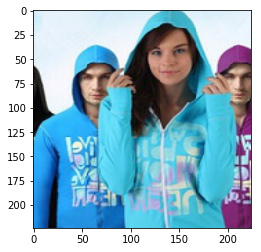

In [29]:
rnd1 = np.random.randint(len(train_dset))
im1, lbl1 = train_dset[rnd1]
imshow(tensor_to_numpy(im1, args.pretrain_dset_mean, args.pretrain_dset_std))
print(lbl1)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.]


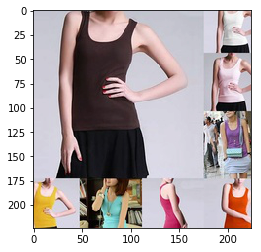

In [30]:
rnd2 = np.random.randint(len(val_dset))
im2, lbl2 = val_dset[rnd2]
imshow(tensor_to_numpy(im2, args.pretrain_dset_mean, args.pretrain_dset_std))
print(lbl2)

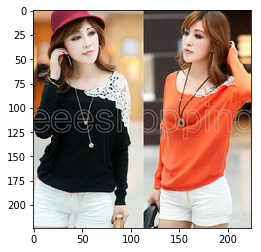

In [31]:
rnd3 = np.random.randint(len(test_dset))
im3 = test_dset[rnd3]
imshow(tensor_to_numpy(im3, args.pretrain_dset_mean, args.pretrain_dset_std))


# DataLoader

In [32]:
if args.distributed:
    dist.init_process_group(backend=args.dist_backend,
                            init_method=args.dist_url,
                            world_size=args.world_size)


In [33]:
from torch.utils.data.distributed import DistributedSampler 


if args.distributed:
  train_sampler = DistributedSampler(train_dset)
else:
  train_sampler = None

train_loader = torch.utils.data.DataLoader(train_dset,
                                           batch_size=args.batch_size,
                                           shuffle=(train_sampler is None),
                                           num_workers=args.num_workers,
                                           pin_memory=True,
                                           sampler=train_sampler
                                          )

val_loader = torch.utils.data.DataLoader(val_dset,
                                         batch_size=args.batch_size,
                                         shuffle=False,
                                         num_workers=args.num_workers,
                                         pin_memory=True
                                        )

test_loader = torch.utils.data.DataLoader(test_dset,
                                         batch_size=args.batch_size,
                                         shuffle=False,
                                         num_workers=args.num_workers,
                                         pin_memory=True
                                        )



In [34]:
# train_images, train_labels = next(iter(train_loader))

In [35]:
# rnd11 = np.random.randint(args.batch_size)
# print(train_images[rnd11,:,:,:])
# print(train_labels[rnd11, :])

In [36]:
# val_images, val_labels = next(iter(val_loader))

In [37]:
# rnd21 = np.random.randint(args.batch_size)
# print(val_images[rnd21,:,:,:])
# print(val_labels[rnd21, :])


# Model

In [38]:
import torch.nn.init as weight_init


class FCWithLogSigmoid(nn.Module):
  
  def __init__(self, num_inputs, num_outputs):
    super(FCWithLogSigmoid, self).__init__()
    self.linear = nn.Linear(num_inputs, num_outputs)
    self.logsigmoid = nn.LogSigmoid()
    
  def forward(self, x):
    return self.logsigmoid(self.linear(x))


def create_model(arch, num_labels=228, fv_size=2048, pretrained=True, resume=False, distributed=False):
  if pretrained:
      print("=> using pre-trained model '{}'".format(arch))
      model = models.__dict__[arch](pretrained=True)
  else:
      print("=> creating model '{}'".format(arch))
      model = models.__dict__[arch]()
  model.fc = FCWithLogSigmoid(fv_size, num_labels)
  if not distributed:
      if arch.startswith('alexnet') or arch.startswith('vgg'):
          model.features = torch.nn.DataParallel(model.features)
          model.cuda()
      else:
          model = torch.nn.DataParallel(model).cuda()
  else:
      model.cuda()
      model = torch.nn.parallel.DistributedDataParallel(model)
  return model


In [39]:
def count_parameters(model):
  """source: https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/9"""
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [40]:
model = create_model(args.arch,
                     num_labels=args.num_labels,
                     fv_size=args.fv_size,
                     pretrained=args.pretrained,
                     resume=args.resume,
                     distributed=args.distributed)

=> using pre-trained model 'resnet101'


In [41]:
print("Neural Network has ", count_parameters(model), " trainable parameters")

Neural Network has  42967332  trainable parameters


In [42]:
class WeightUpdateTracker:
    
    def __init__(self, model):
        with torch.no_grad():
            self.num_param_tensors = len(list(model.parameters()))
            self.prev_pnorms = torch.zeros(self.num_param_tensors) 
            self.curr_pnorms = self.parameter_norms(model) 

    def parameter_norms(self, model):
        with torch.no_grad():
            pnorms = torch.zeros(self.num_param_tensors)
            for i, x in enumerate(list(model.parameters())):
                pnorms[i] = x.norm().item()
            return pnorms
        
    def track(self, model):
        with torch.no_grad():
            self.prev_pnorms = self.curr_pnorms.clone()
            self.curr_pnorms = self.parameter_norms(model)
            self.delta = (self.curr_pnorms - self.prev_pnorms) / self.prev_pnorms

            
    def __repr__(self):
        with torch.no_grad():
            return self.delta.__repr__()
        

# Loss Function


In [43]:
criterion = torch.nn.BCEWithLogitsLoss().cuda()

# Update Rule

In [44]:
optimizer = optim.Adam(model.parameters(),
                       amsgrad=True,
                       lr=args.optimizer_learning_rate,
                       betas=(0.9, 0.999),
                       eps=1e-8,
                       weight_decay=0.0
                      )
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                           mode='max',   # F1 measure
                                           patience=args.scheduler_patience,
                                           threshold=args.scheduler_threshold,
                                           factor=args.scheduler_factor,
                                           verbose=1
                                          )


# Training Loop


In [45]:
def load_checkpoint(model, optimizer, scheduler, args, resume=True, ckpt=None):
    """optionally resume from a checkpoint."""
    best_f1 = 0
    if args.resume:
        if os.path.isfile(ckpt):
            print("=> loading checkpoint '{}'".format(ckpt))
            checkpoint = torch.load(ckpt)
            args.start_epoch = checkpoint['epoch']
            best_f1 = checkpoint['best_f1']
            model.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
          #  scheduler.load_state_dict(checkpoint['scheduler'])
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(args.resume, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(ckpt))
            best_f1 = 0
    return (model, optimizer, scheduler, args, best_f1)

In [46]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar', best_model_filename='model_best.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, best_model_filename)

In [47]:
class F1MicroAverageMeter(object):
    """Computes and stores F1 store"""
    def __init__(self, threshold=0.5, small=1e-12):
        self.threshold = threshold
        self.small = small
        self.reset()

    def reset(self):
        self.TP = 0.0
        self.FP = 0.0
        self.FN = 0.0
        self.TN = 0.0
        self.precision = 0.0
        self.recall = 0.0
        self.f1 = 0.0

    def update(self, labels, pred):
        tp, fp, fn, tn = self.confusion_matrix_(labels, pred)
        self.TP += tp
        self.FP += fp
        self.FN += fn
        self.TN += tn
        self.precision = self.TP / (self.small + self.TP + self.FP)
        self.recall = self.TP / (self.small + self.TP + self.FN)
        self.f1 = (2.0 * self.precision * self.recall) / (self.small + self.precision + self.recall)
        
    def confusion_matrix_(self, labels, pred):
        with torch.no_grad():
            real = labels
            fake = 1.0 - real
            pos = pred.ge(self.threshold).float()
            neg = 1.0 - pos
            tp = torch.sum(real * pos).item()
            fp = torch.sum(fake * pos).item()
            fn = torch.sum(real * neg).item()
            tn = torch.sum(fake * neg).item()
            return (tp, fp, fn, tn)
              

In [48]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [49]:
def adjust_learning_rate(optimizer, scheduler, epoch, measure, args):
    if not args.test_overfit:
        scheduler.step(measure)


In [50]:
def train(train_loader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    cmpoint5 = F1MicroAverageMeter(threshold=0.5)

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        target = target.cuda(non_blocking=True)

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # measure F1 and record loss
        losses.update(loss.item(), input.size(0))
        cmpoint5.update(target, torch.exp(output))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        
        

        if i % args.print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Precision {cmpoint5.precision:.3f}\t'
                  'Recall {cmpoint5.recall:.3f}\t'
                  'F1 {cmpoint5.f1:.3f}'.format(
                   epoch, i, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses, cmpoint5=cmpoint5))

In [51]:
def validate(val_loader, model, criterion):
    batch_time = AverageMeter()
    losses = AverageMeter()
    cmpoint5 = F1MicroAverageMeter(threshold=0.5)

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (input, target) in enumerate(val_loader):
            target = target.cuda(non_blocking=True)

            # compute output
            output = model(input)
            loss = criterion(output, target)

            # measure F1 and record loss
            losses.update(loss.item(), input.size(0))
            cmpoint5.update(target, torch.exp(output))
            
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % args.print_freq == 0:
                 print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Precision {cmpoint5.precision:.3f}\t'
                      'Recall {cmpoint5.recall:.3f}\t'
                      'F1 {cmpoint5.f1:.3f}'.format(
                       i, len(val_loader), batch_time=batch_time, loss=losses,
                       cmpoint5=cmpoint5))

        print(' * Precision {cmpoint5.precision:.3f} Recall {cmpoint5.recall:.3f} F1 {cmpoint5.f1:.3f}'
              .format(cmpoint5=cmpoint5))

    return cmpoint5.f1

In [52]:
def test(ofname, pfname, args, test_dset, test_loader, best_model_ckpt, model, threshold=0.5, epoch=0):
    
#     checkpoint = torch.load(best_model_ckpt)
#     model.load_state_dict(checkpoint['state_dict'])
    
    batch_time = AverageMeter()
    res = OrderedDict()

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, input in enumerate(test_loader):
            # compute output
            output = model(input)
            spout = coo_matrix(torch.exp(output).ge(threshold).int().cpu().numpy())
            for p in zip(spout.row, spout.col):
                imid = test_dset.image_ids[i* args.batch_size+p[0]]
                if imid not in res.keys():
                    res[imid] = [p[1]+1]
                else:
                    res[imid].append(p[1]+1)
            
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % args.print_freq == 0:
                 print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'.format(
                       i, len(test_loader), batch_time=batch_time))
    
    ofname_ = "%s%s%03d_%s" % (os.path.dirname(ofname), os.sep, epoch, os.path.basename(ofname))
    with open(ofname_, "w") as ofd:
        ofd.write("image_id,label_id\n")
        for k, v in res.items():
            ofd.write("%d,%s\n" % (k, " ".join(map(str,v))))
            
    pfname_ = "%s%s%03d_%s" % (os.path.dirname(pfname), os.sep, epoch, os.path.basename(pfname))
    with open(pfname_, "w") as pfd:
        json.dump(vars(args), pfd, sort_keys=True, indent=4)
            
    print("Output written to %s\n" % ofname_)
    print("Program parameters written to %s\n" % pfname_)
    sys.stdout.flush()

In [53]:
def train_loop(train_loader, val_loader, test_loader, test_dset, args, optimizer, scheduler, model, criterion, threshold=0.5):
    if args.evaluate:
        validate(val_loader, model, criterion)
    else:
        model, optimizer, scheduler, args, best_f1 = load_checkpoint(model, optimizer, scheduler, args, resume=args.resume, ckpt=args.ckpt)
        wut = None
        if args.debug_weights:
            wut = WeightUpdateTracker(model)
        for epoch in range(args.start_epoch, args.epochs):
            if args.distributed:
                train_sampler.set_epoch(epoch)
    #         adjust_learning_rate(optimizer, epoch)

            # train for one epoch
            train(train_loader, model, criterion, optimizer, epoch)

            if args.debug_weights:
                # debug: track weight updates
                wut.track(model)
                print(wut)

            # evaluate on validation set
            f1 = validate(val_loader, model, criterion)

            # remember best f1 and save checkpoint
            is_best = f1 > best_f1
            best_f1 = max(f1, best_f1)
            save_checkpoint({
                'epoch': epoch + 1,
                'arch': args.arch,
                'state_dict': model.state_dict(),
                'best_f1': best_f1,
                'optimizer' : optimizer.state_dict(),
               # 'scheduler' : scheduler.state_dict(),
            }, is_best, filename=args.ckpt, best_model_filename=args.best)

            if is_best:
                print("BEST: ", epoch)
                sys.stdout.flush()
            adjust_learning_rate(optimizer, scheduler, epoch, f1, args)
            test(args.output_file, args.params_file, args, test_dset, test_loader, args.best, model, threshold=args.threshold, epoch=epoch)            
            


In [54]:
train_loop(train_loader, val_loader, test_loader, test_dset, args, optimizer, scheduler, model, criterion, threshold=args.threshold)

Epoch: [0][0/614]	Time 5.648 (5.648)	Data 1.507 (1.507)	Loss 0.4249 (0.4249)	Precision 0.024	Recall 0.522	F1 0.047
Epoch: [0][16/614]	Time 0.356 (0.658)	Data 0.000 (0.089)	Loss 0.1873 (0.3040)	Precision 0.067	Recall 0.304	F1 0.109
Epoch: [0][32/614]	Time 0.346 (0.506)	Data 0.000 (0.046)	Loss 0.0965 (0.2182)	Precision 0.102	Recall 0.262	F1 0.147
Epoch: [0][48/614]	Time 0.346 (0.454)	Data 0.001 (0.031)	Loss 0.0835 (0.1754)	Precision 0.135	Recall 0.249	F1 0.176
Epoch: [0][64/614]	Time 0.350 (0.428)	Data 0.000 (0.023)	Loss 0.0822 (0.1531)	Precision 0.166	Recall 0.245	F1 0.198
Epoch: [0][80/614]	Time 0.350 (0.412)	Data 0.000 (0.019)	Loss 0.0800 (0.1386)	Precision 0.192	Recall 0.243	F1 0.215
Epoch: [0][96/614]	Time 0.355 (0.401)	Data 0.000 (0.016)	Loss 0.0803 (0.1289)	Precision 0.218	Recall 0.244	F1 0.230
Epoch: [0][112/614]	Time 0.353 (0.394)	Data 0.000 (0.014)	Loss 0.0724 (0.1222)	Precision 0.240	Recall 0.242	F1 0.241
Epoch: [0][128/614]	Time 0.350 (0.388)	Data 0.000 (0.012)	Loss 0.0763 (0

 * Precision 0.622 Recall 0.325 F1 0.427
BEST:  0
Test: [0/2482]	Time 0.615 (0.615)	
Test: [16/2482]	Time 0.101 (0.143)	
Test: [32/2482]	Time 0.108 (0.123)	
Test: [48/2482]	Time 0.102 (0.117)	
Test: [64/2482]	Time 0.105 (0.113)	
Test: [80/2482]	Time 0.102 (0.111)	
Test: [96/2482]	Time 0.102 (0.109)	
Test: [112/2482]	Time 0.107 (0.108)	
Test: [128/2482]	Time 0.102 (0.108)	
Test: [144/2482]	Time 0.102 (0.107)	
Test: [160/2482]	Time 0.100 (0.106)	
Test: [176/2482]	Time 0.102 (0.106)	
Test: [192/2482]	Time 0.101 (0.106)	
Test: [208/2482]	Time 0.101 (0.105)	
Test: [224/2482]	Time 0.100 (0.105)	
Test: [240/2482]	Time 0.100 (0.105)	
Test: [256/2482]	Time 0.101 (0.105)	
Test: [272/2482]	Time 0.102 (0.105)	
Test: [288/2482]	Time 0.103 (0.105)	
Test: [304/2482]	Time 0.102 (0.104)	
Test: [320/2482]	Time 0.105 (0.104)	
Test: [336/2482]	Time 0.101 (0.104)	
Test: [352/2482]	Time 0.101 (0.104)	
Test: [368/2482]	Time 0.102 (0.104)	
Test: [384/2482]	Time 0.102 (0.104)	
Test: [400/2482]	Time 0.114 (0.10

Epoch: [1][272/614]	Time 0.345 (0.352)	Data 0.000 (0.004)	Loss 0.0651 (0.0692)	Precision 0.610	Recall 0.369	F1 0.460
Epoch: [1][288/614]	Time 0.351 (0.352)	Data 0.000 (0.004)	Loss 0.0683 (0.0694)	Precision 0.610	Recall 0.369	F1 0.460
Epoch: [1][304/614]	Time 0.351 (0.352)	Data 0.000 (0.003)	Loss 0.0664 (0.0694)	Precision 0.609	Recall 0.369	F1 0.460
Epoch: [1][320/614]	Time 0.346 (0.352)	Data 0.000 (0.003)	Loss 0.0673 (0.0695)	Precision 0.608	Recall 0.369	F1 0.459
Epoch: [1][336/614]	Time 0.348 (0.351)	Data 0.000 (0.003)	Loss 0.0782 (0.0695)	Precision 0.607	Recall 0.368	F1 0.458
Epoch: [1][352/614]	Time 0.345 (0.351)	Data 0.001 (0.003)	Loss 0.0761 (0.0695)	Precision 0.608	Recall 0.369	F1 0.460
Epoch: [1][368/614]	Time 0.351 (0.351)	Data 0.000 (0.003)	Loss 0.0796 (0.0694)	Precision 0.608	Recall 0.370	F1 0.460
Epoch: [1][384/614]	Time 0.346 (0.351)	Data 0.001 (0.003)	Loss 0.0707 (0.0694)	Precision 0.609	Recall 0.370	F1 0.460
Epoch: [1][400/614]	Time 0.348 (0.351)	Data 0.000 (0.003)	Loss 0

Test: [832/2482]	Time 0.109 (0.104)	
Test: [848/2482]	Time 0.103 (0.104)	
Test: [864/2482]	Time 0.103 (0.104)	
Test: [880/2482]	Time 0.103 (0.104)	
Test: [896/2482]	Time 0.101 (0.104)	
Test: [912/2482]	Time 0.102 (0.104)	
Test: [928/2482]	Time 0.103 (0.104)	
Test: [944/2482]	Time 0.102 (0.104)	
Test: [960/2482]	Time 0.102 (0.104)	
Test: [976/2482]	Time 0.103 (0.104)	
Test: [992/2482]	Time 0.103 (0.104)	
Test: [1008/2482]	Time 0.103 (0.104)	
Test: [1024/2482]	Time 0.103 (0.104)	
Test: [1040/2482]	Time 0.105 (0.104)	
Test: [1056/2482]	Time 0.101 (0.104)	
Test: [1072/2482]	Time 0.105 (0.104)	
Test: [1088/2482]	Time 0.105 (0.104)	
Test: [1104/2482]	Time 0.102 (0.104)	
Test: [1120/2482]	Time 0.105 (0.104)	
Test: [1136/2482]	Time 0.106 (0.104)	
Test: [1152/2482]	Time 0.107 (0.104)	
Test: [1168/2482]	Time 0.102 (0.104)	
Test: [1184/2482]	Time 0.101 (0.104)	
Test: [1200/2482]	Time 0.102 (0.104)	
Test: [1216/2482]	Time 0.103 (0.104)	
Test: [1232/2482]	Time 0.104 (0.104)	
Test: [1248/2482]	Time 

Epoch: [2][544/614]	Time 0.337 (0.343)	Data 0.000 (0.002)	Loss 0.0694 (0.0667)	Precision 0.610	Recall 0.404	F1 0.486
Epoch: [2][560/614]	Time 0.336 (0.343)	Data 0.000 (0.002)	Loss 0.0585 (0.0667)	Precision 0.610	Recall 0.404	F1 0.486
Epoch: [2][576/614]	Time 0.336 (0.342)	Data 0.000 (0.002)	Loss 0.0742 (0.0667)	Precision 0.610	Recall 0.405	F1 0.487
Epoch: [2][592/614]	Time 0.336 (0.342)	Data 0.000 (0.002)	Loss 0.0581 (0.0667)	Precision 0.609	Recall 0.405	F1 0.487
Epoch: [2][608/614]	Time 0.337 (0.342)	Data 0.000 (0.002)	Loss 0.0620 (0.0667)	Precision 0.610	Recall 0.405	F1 0.487
Test: [0/619]	Time 0.490 (0.490)	Loss 0.0878 (0.0878)	Precision 0.698	Recall 0.451	F1 0.548
Test: [16/619]	Time 0.100 (0.133)	Loss 0.0826 (0.0973)	Precision 0.654	Recall 0.376	F1 0.478
Test: [32/619]	Time 0.100 (0.117)	Loss 0.0877 (0.0950)	Precision 0.656	Recall 0.381	F1 0.482
Test: [48/619]	Time 0.099 (0.111)	Loss 0.0935 (0.0959)	Precision 0.667	Recall 0.382	F1 0.486
Test: [64/619]	Time 0.100 (0.109)	Loss 0.086

Test: [1680/2482]	Time 0.101 (0.101)	
Test: [1696/2482]	Time 0.100 (0.101)	
Test: [1712/2482]	Time 0.101 (0.101)	
Test: [1728/2482]	Time 0.100 (0.101)	
Test: [1744/2482]	Time 0.100 (0.101)	
Test: [1760/2482]	Time 0.101 (0.101)	
Test: [1776/2482]	Time 0.102 (0.101)	
Test: [1792/2482]	Time 0.101 (0.101)	
Test: [1808/2482]	Time 0.101 (0.101)	
Test: [1824/2482]	Time 0.100 (0.101)	
Test: [1840/2482]	Time 0.103 (0.101)	
Test: [1856/2482]	Time 0.100 (0.101)	
Test: [1872/2482]	Time 0.100 (0.101)	
Test: [1888/2482]	Time 0.100 (0.101)	
Test: [1904/2482]	Time 0.101 (0.101)	
Test: [1920/2482]	Time 0.100 (0.101)	
Test: [1936/2482]	Time 0.101 (0.101)	
Test: [1952/2482]	Time 0.100 (0.101)	
Test: [1968/2482]	Time 0.100 (0.101)	
Test: [1984/2482]	Time 0.101 (0.101)	
Test: [2000/2482]	Time 0.100 (0.101)	
Test: [2016/2482]	Time 0.100 (0.101)	
Test: [2032/2482]	Time 0.100 (0.101)	
Test: [2048/2482]	Time 0.100 (0.101)	
Test: [2064/2482]	Time 0.100 (0.101)	
Test: [2080/2482]	Time 0.099 (0.101)	
Test: [2096/

Test: [240/619]	Time 0.104 (0.104)	Loss 0.0993 (0.0952)	Precision 0.643	Recall 0.416	F1 0.505
Test: [256/619]	Time 0.102 (0.104)	Loss 0.1318 (0.0954)	Precision 0.643	Recall 0.416	F1 0.505
Test: [272/619]	Time 0.108 (0.104)	Loss 0.1066 (0.0958)	Precision 0.641	Recall 0.414	F1 0.503
Test: [288/619]	Time 0.101 (0.104)	Loss 0.0962 (0.0959)	Precision 0.641	Recall 0.413	F1 0.502
Test: [304/619]	Time 0.101 (0.104)	Loss 0.1135 (0.0963)	Precision 0.641	Recall 0.412	F1 0.502
Test: [320/619]	Time 0.103 (0.104)	Loss 0.1058 (0.0965)	Precision 0.640	Recall 0.411	F1 0.501
Test: [336/619]	Time 0.101 (0.104)	Loss 0.1008 (0.0969)	Precision 0.640	Recall 0.410	F1 0.500
Test: [352/619]	Time 0.101 (0.104)	Loss 0.1081 (0.0973)	Precision 0.639	Recall 0.409	F1 0.499
Test: [368/619]	Time 0.102 (0.104)	Loss 0.0893 (0.0973)	Precision 0.639	Recall 0.409	F1 0.498
Test: [384/619]	Time 0.102 (0.104)	Loss 0.0972 (0.0972)	Precision 0.638	Recall 0.409	F1 0.499
Test: [400/619]	Time 0.118 (0.104)	Loss 0.1037 (0.0973)	Prec

Epoch: [4][0/614]	Time 1.119 (1.119)	Data 0.780 (0.780)	Loss 0.0604 (0.0604)	Precision 0.705	Recall 0.478	F1 0.570
Epoch: [4][16/614]	Time 0.345 (0.387)	Data 0.001 (0.046)	Loss 0.0727 (0.0635)	Precision 0.596	Recall 0.433	F1 0.501
Epoch: [4][32/614]	Time 0.340 (0.364)	Data 0.000 (0.024)	Loss 0.0544 (0.0624)	Precision 0.605	Recall 0.442	F1 0.510
Epoch: [4][48/614]	Time 0.341 (0.357)	Data 0.000 (0.016)	Loss 0.0557 (0.0632)	Precision 0.620	Recall 0.443	F1 0.517
Epoch: [4][64/614]	Time 0.342 (0.353)	Data 0.000 (0.012)	Loss 0.0621 (0.0634)	Precision 0.624	Recall 0.441	F1 0.517
Epoch: [4][80/614]	Time 0.344 (0.351)	Data 0.000 (0.010)	Loss 0.0731 (0.0634)	Precision 0.628	Recall 0.442	F1 0.519
Epoch: [4][96/614]	Time 0.340 (0.349)	Data 0.000 (0.009)	Loss 0.0688 (0.0632)	Precision 0.628	Recall 0.445	F1 0.521
Epoch: [4][112/614]	Time 0.340 (0.348)	Data 0.000 (0.007)	Loss 0.0707 (0.0633)	Precision 0.628	Recall 0.445	F1 0.521
Epoch: [4][128/614]	Time 0.344 (0.347)	Data 0.000 (0.007)	Loss 0.0627 (0

 * Precision 0.638 Recall 0.390 F1 0.484
Test: [0/2482]	Time 1.278 (1.278)	
Test: [16/2482]	Time 0.101 (0.172)	
Test: [32/2482]	Time 0.101 (0.138)	
Test: [48/2482]	Time 0.100 (0.126)	
Test: [64/2482]	Time 0.101 (0.120)	
Test: [80/2482]	Time 0.100 (0.116)	
Test: [96/2482]	Time 0.100 (0.114)	
Test: [112/2482]	Time 0.103 (0.113)	
Test: [128/2482]	Time 0.102 (0.111)	
Test: [144/2482]	Time 0.101 (0.110)	
Test: [160/2482]	Time 0.101 (0.109)	
Test: [176/2482]	Time 0.100 (0.108)	
Test: [192/2482]	Time 0.100 (0.108)	
Test: [208/2482]	Time 0.100 (0.107)	
Test: [224/2482]	Time 0.100 (0.107)	
Test: [240/2482]	Time 0.100 (0.107)	
Test: [256/2482]	Time 0.100 (0.106)	
Test: [272/2482]	Time 0.100 (0.106)	
Test: [288/2482]	Time 0.101 (0.106)	
Test: [304/2482]	Time 0.101 (0.106)	
Test: [320/2482]	Time 0.102 (0.105)	
Test: [336/2482]	Time 0.101 (0.105)	
Test: [352/2482]	Time 0.101 (0.105)	
Test: [368/2482]	Time 0.100 (0.105)	
Test: [384/2482]	Time 0.101 (0.105)	
Test: [400/2482]	Time 0.101 (0.105)	
Test:

Epoch: [5][272/614]	Time 0.343 (0.345)	Data 0.000 (0.003)	Loss 0.0615 (0.0621)	Precision 0.619	Recall 0.455	F1 0.525
Epoch: [5][288/614]	Time 0.343 (0.344)	Data 0.000 (0.003)	Loss 0.0649 (0.0622)	Precision 0.619	Recall 0.456	F1 0.525
Epoch: [5][304/614]	Time 0.345 (0.344)	Data 0.000 (0.003)	Loss 0.0702 (0.0622)	Precision 0.618	Recall 0.458	F1 0.526
Epoch: [5][320/614]	Time 0.344 (0.344)	Data 0.000 (0.002)	Loss 0.0711 (0.0622)	Precision 0.618	Recall 0.457	F1 0.526
Epoch: [5][336/614]	Time 0.343 (0.344)	Data 0.000 (0.002)	Loss 0.0617 (0.0621)	Precision 0.619	Recall 0.458	F1 0.527
Epoch: [5][352/614]	Time 0.346 (0.344)	Data 0.000 (0.002)	Loss 0.0539 (0.0619)	Precision 0.619	Recall 0.460	F1 0.528
Epoch: [5][368/614]	Time 0.345 (0.344)	Data 0.000 (0.002)	Loss 0.0571 (0.0620)	Precision 0.618	Recall 0.459	F1 0.527
Epoch: [5][384/614]	Time 0.354 (0.344)	Data 0.001 (0.002)	Loss 0.0702 (0.0621)	Precision 0.618	Recall 0.459	F1 0.526
Epoch: [5][400/614]	Time 0.340 (0.344)	Data 0.000 (0.002)	Loss 0

Test: [832/2482]	Time 0.100 (0.104)	
Test: [848/2482]	Time 0.120 (0.104)	
Test: [864/2482]	Time 0.121 (0.104)	
Test: [880/2482]	Time 0.101 (0.104)	
Test: [896/2482]	Time 0.106 (0.104)	
Test: [912/2482]	Time 0.107 (0.104)	
Test: [928/2482]	Time 0.104 (0.104)	
Test: [944/2482]	Time 0.101 (0.104)	
Test: [960/2482]	Time 0.107 (0.104)	
Test: [976/2482]	Time 0.103 (0.104)	
Test: [992/2482]	Time 0.101 (0.104)	
Test: [1008/2482]	Time 0.108 (0.104)	
Test: [1024/2482]	Time 0.118 (0.104)	
Test: [1040/2482]	Time 0.107 (0.104)	
Test: [1056/2482]	Time 0.101 (0.104)	
Test: [1072/2482]	Time 0.100 (0.104)	
Test: [1088/2482]	Time 0.112 (0.104)	
Test: [1104/2482]	Time 0.101 (0.104)	
Test: [1120/2482]	Time 0.107 (0.104)	
Test: [1136/2482]	Time 0.105 (0.104)	
Test: [1152/2482]	Time 0.102 (0.104)	
Test: [1168/2482]	Time 0.101 (0.104)	
Test: [1184/2482]	Time 0.107 (0.104)	
Test: [1200/2482]	Time 0.102 (0.104)	
Test: [1216/2482]	Time 0.102 (0.104)	
Test: [1232/2482]	Time 0.109 (0.104)	
Test: [1248/2482]	Time 

Epoch: [6][544/614]	Time 0.368 (0.362)	Data 0.001 (0.002)	Loss 0.0580 (0.0613)	Precision 0.622	Recall 0.472	F1 0.537
Epoch: [6][560/614]	Time 0.371 (0.363)	Data 0.000 (0.002)	Loss 0.0603 (0.0613)	Precision 0.622	Recall 0.472	F1 0.537
Epoch: [6][576/614]	Time 0.368 (0.363)	Data 0.000 (0.002)	Loss 0.0650 (0.0614)	Precision 0.622	Recall 0.472	F1 0.536
Epoch: [6][592/614]	Time 0.367 (0.363)	Data 0.001 (0.002)	Loss 0.0609 (0.0614)	Precision 0.621	Recall 0.472	F1 0.536
Epoch: [6][608/614]	Time 0.372 (0.363)	Data 0.000 (0.002)	Loss 0.0550 (0.0614)	Precision 0.620	Recall 0.471	F1 0.536
Test: [0/619]	Time 0.636 (0.636)	Loss 0.0831 (0.0831)	Precision 0.670	Recall 0.549	F1 0.603
Test: [16/619]	Time 0.108 (0.141)	Loss 0.0809 (0.0962)	Precision 0.618	Recall 0.439	F1 0.513
Test: [32/619]	Time 0.109 (0.125)	Loss 0.0820 (0.0930)	Precision 0.627	Recall 0.449	F1 0.523
Test: [48/619]	Time 0.107 (0.120)	Loss 0.0944 (0.0941)	Precision 0.630	Recall 0.446	F1 0.522
Test: [64/619]	Time 0.106 (0.117)	Loss 0.083

Test: [1680/2482]	Time 0.109 (0.110)	
Test: [1696/2482]	Time 0.111 (0.110)	
Test: [1712/2482]	Time 0.106 (0.110)	
Test: [1728/2482]	Time 0.108 (0.110)	
Test: [1744/2482]	Time 0.108 (0.110)	
Test: [1760/2482]	Time 0.108 (0.110)	
Test: [1776/2482]	Time 0.110 (0.110)	
Test: [1792/2482]	Time 0.108 (0.110)	
Test: [1808/2482]	Time 0.107 (0.110)	
Test: [1824/2482]	Time 0.111 (0.110)	
Test: [1840/2482]	Time 0.108 (0.110)	
Test: [1856/2482]	Time 0.107 (0.110)	
Test: [1872/2482]	Time 0.102 (0.110)	
Test: [1888/2482]	Time 0.101 (0.110)	
Test: [1904/2482]	Time 0.102 (0.110)	
Test: [1920/2482]	Time 0.101 (0.109)	
Test: [1936/2482]	Time 0.102 (0.109)	
Test: [1952/2482]	Time 0.102 (0.109)	
Test: [1968/2482]	Time 0.102 (0.109)	
Test: [1984/2482]	Time 0.102 (0.109)	
Test: [2000/2482]	Time 0.101 (0.109)	
Test: [2016/2482]	Time 0.101 (0.109)	
Test: [2032/2482]	Time 0.101 (0.109)	
Test: [2048/2482]	Time 0.101 (0.109)	
Test: [2064/2482]	Time 0.102 (0.109)	
Test: [2080/2482]	Time 0.101 (0.109)	
Test: [2096/

Test: [240/619]	Time 0.101 (0.103)	Loss 0.0989 (0.0952)	Precision 0.652	Recall 0.424	F1 0.514
Test: [256/619]	Time 0.101 (0.103)	Loss 0.1327 (0.0952)	Precision 0.653	Recall 0.423	F1 0.514
Test: [272/619]	Time 0.101 (0.103)	Loss 0.1053 (0.0956)	Precision 0.651	Recall 0.422	F1 0.512
Test: [288/619]	Time 0.100 (0.103)	Loss 0.1004 (0.0958)	Precision 0.649	Recall 0.421	F1 0.511
Test: [304/619]	Time 0.102 (0.103)	Loss 0.1187 (0.0961)	Precision 0.649	Recall 0.420	F1 0.510
Test: [320/619]	Time 0.101 (0.103)	Loss 0.1046 (0.0964)	Precision 0.648	Recall 0.419	F1 0.509
Test: [336/619]	Time 0.100 (0.103)	Loss 0.1036 (0.0969)	Precision 0.648	Recall 0.418	F1 0.508
Test: [352/619]	Time 0.102 (0.102)	Loss 0.1067 (0.0971)	Precision 0.647	Recall 0.417	F1 0.507
Test: [368/619]	Time 0.101 (0.102)	Loss 0.0900 (0.0971)	Precision 0.646	Recall 0.417	F1 0.507
Test: [384/619]	Time 0.102 (0.102)	Loss 0.0911 (0.0971)	Precision 0.646	Recall 0.417	F1 0.507
Test: [400/619]	Time 0.101 (0.102)	Loss 0.1070 (0.0971)	Prec

Epoch: [8][0/614]	Time 1.000 (1.000)	Data 0.662 (0.662)	Loss 0.0641 (0.0641)	Precision 0.632	Recall 0.462	F1 0.534
Epoch: [8][16/614]	Time 0.339 (0.380)	Data 0.000 (0.039)	Loss 0.0643 (0.0596)	Precision 0.626	Recall 0.474	F1 0.539
Epoch: [8][32/614]	Time 0.364 (0.366)	Data 0.000 (0.020)	Loss 0.0605 (0.0588)	Precision 0.633	Recall 0.480	F1 0.546
Epoch: [8][48/614]	Time 0.371 (0.367)	Data 0.000 (0.014)	Loss 0.0578 (0.0588)	Precision 0.625	Recall 0.489	F1 0.548
Epoch: [8][64/614]	Time 0.368 (0.367)	Data 0.000 (0.011)	Loss 0.0581 (0.0589)	Precision 0.623	Recall 0.491	F1 0.549
Epoch: [8][80/614]	Time 0.368 (0.367)	Data 0.000 (0.009)	Loss 0.0540 (0.0592)	Precision 0.619	Recall 0.490	F1 0.547
Epoch: [8][96/614]	Time 0.367 (0.368)	Data 0.000 (0.007)	Loss 0.0611 (0.0593)	Precision 0.615	Recall 0.486	F1 0.543
Epoch: [8][112/614]	Time 0.372 (0.368)	Data 0.000 (0.006)	Loss 0.0706 (0.0594)	Precision 0.617	Recall 0.484	F1 0.543
Epoch: [8][128/614]	Time 0.375 (0.369)	Data 0.000 (0.005)	Loss 0.0597 (0

 * Precision 0.626 Recall 0.437 F1 0.515
BEST:  8
Test: [0/2482]	Time 0.701 (0.701)	
Test: [16/2482]	Time 0.106 (0.144)	
Test: [32/2482]	Time 0.105 (0.127)	
Test: [48/2482]	Time 0.116 (0.121)	
Test: [64/2482]	Time 0.106 (0.117)	
Test: [80/2482]	Time 0.107 (0.116)	
Test: [96/2482]	Time 0.108 (0.115)	
Test: [112/2482]	Time 0.115 (0.114)	
Test: [128/2482]	Time 0.109 (0.113)	
Test: [144/2482]	Time 0.109 (0.113)	
Test: [160/2482]	Time 0.108 (0.113)	
Test: [176/2482]	Time 0.106 (0.112)	
Test: [192/2482]	Time 0.110 (0.112)	
Test: [208/2482]	Time 0.110 (0.112)	
Test: [224/2482]	Time 0.109 (0.111)	
Test: [240/2482]	Time 0.107 (0.111)	
Test: [256/2482]	Time 0.109 (0.111)	
Test: [272/2482]	Time 0.107 (0.111)	
Test: [288/2482]	Time 0.110 (0.111)	
Test: [304/2482]	Time 0.108 (0.111)	
Test: [320/2482]	Time 0.110 (0.110)	
Test: [336/2482]	Time 0.107 (0.110)	
Test: [352/2482]	Time 0.109 (0.110)	
Test: [368/2482]	Time 0.113 (0.110)	
Test: [384/2482]	Time 0.107 (0.110)	
Test: [400/2482]	Time 0.107 (0.11

Epoch: [9][272/614]	Time 0.341 (0.354)	Data 0.000 (0.003)	Loss 0.0673 (0.0583)	Precision 0.634	Recall 0.510	F1 0.565
Epoch: [9][288/614]	Time 0.345 (0.353)	Data 0.000 (0.003)	Loss 0.0590 (0.0583)	Precision 0.634	Recall 0.509	F1 0.565
Epoch: [9][304/614]	Time 0.344 (0.353)	Data 0.000 (0.003)	Loss 0.0486 (0.0583)	Precision 0.634	Recall 0.509	F1 0.564
Epoch: [9][320/614]	Time 0.345 (0.352)	Data 0.000 (0.003)	Loss 0.0450 (0.0584)	Precision 0.634	Recall 0.509	F1 0.564
Epoch: [9][336/614]	Time 0.345 (0.352)	Data 0.000 (0.003)	Loss 0.0526 (0.0584)	Precision 0.632	Recall 0.508	F1 0.563
Epoch: [9][352/614]	Time 0.342 (0.351)	Data 0.000 (0.003)	Loss 0.0512 (0.0583)	Precision 0.632	Recall 0.508	F1 0.563
Epoch: [9][368/614]	Time 0.343 (0.351)	Data 0.000 (0.003)	Loss 0.0681 (0.0584)	Precision 0.632	Recall 0.508	F1 0.563
Epoch: [9][384/614]	Time 0.345 (0.351)	Data 0.000 (0.003)	Loss 0.0543 (0.0584)	Precision 0.632	Recall 0.508	F1 0.563
Epoch: [9][400/614]	Time 0.343 (0.350)	Data 0.000 (0.003)	Loss 0

Test: [848/2482]	Time 0.102 (0.104)	
Test: [864/2482]	Time 0.102 (0.104)	
Test: [880/2482]	Time 0.102 (0.104)	
Test: [896/2482]	Time 0.103 (0.104)	
Test: [912/2482]	Time 0.102 (0.104)	
Test: [928/2482]	Time 0.102 (0.104)	
Test: [944/2482]	Time 0.103 (0.104)	
Test: [960/2482]	Time 0.103 (0.104)	
Test: [976/2482]	Time 0.101 (0.104)	
Test: [992/2482]	Time 0.102 (0.104)	
Test: [1008/2482]	Time 0.101 (0.104)	
Test: [1024/2482]	Time 0.102 (0.104)	
Test: [1040/2482]	Time 0.102 (0.104)	
Test: [1056/2482]	Time 0.101 (0.104)	
Test: [1072/2482]	Time 0.102 (0.104)	
Test: [1088/2482]	Time 0.102 (0.104)	
Test: [1104/2482]	Time 0.103 (0.104)	
Test: [1120/2482]	Time 0.102 (0.104)	
Test: [1136/2482]	Time 0.103 (0.104)	
Test: [1152/2482]	Time 0.103 (0.104)	
Test: [1168/2482]	Time 0.103 (0.103)	
Test: [1184/2482]	Time 0.105 (0.103)	
Test: [1200/2482]	Time 0.103 (0.103)	
Test: [1216/2482]	Time 0.103 (0.103)	
Test: [1232/2482]	Time 0.106 (0.103)	
Test: [1248/2482]	Time 0.101 (0.103)	
Test: [1264/2482]	Time

Epoch: [10][544/614]	Time 0.370 (0.360)	Data 0.000 (0.002)	Loss 0.0471 (0.0575)	Precision 0.630	Recall 0.519	F1 0.569
Epoch: [10][560/614]	Time 0.372 (0.360)	Data 0.000 (0.002)	Loss 0.0538 (0.0575)	Precision 0.630	Recall 0.519	F1 0.569
Epoch: [10][576/614]	Time 0.370 (0.361)	Data 0.000 (0.002)	Loss 0.0636 (0.0575)	Precision 0.630	Recall 0.519	F1 0.569
Epoch: [10][592/614]	Time 0.369 (0.361)	Data 0.000 (0.002)	Loss 0.0577 (0.0574)	Precision 0.630	Recall 0.519	F1 0.569
Epoch: [10][608/614]	Time 0.374 (0.361)	Data 0.000 (0.002)	Loss 0.0577 (0.0575)	Precision 0.630	Recall 0.519	F1 0.569
Test: [0/619]	Time 0.586 (0.586)	Loss 0.0869 (0.0869)	Precision 0.648	Recall 0.511	F1 0.571
Test: [16/619]	Time 0.107 (0.138)	Loss 0.0875 (0.0970)	Precision 0.611	Recall 0.443	F1 0.514
Test: [32/619]	Time 0.108 (0.125)	Loss 0.0841 (0.0939)	Precision 0.618	Recall 0.458	F1 0.526
Test: [48/619]	Time 0.108 (0.119)	Loss 0.0960 (0.0950)	Precision 0.627	Recall 0.459	F1 0.530
Test: [64/619]	Time 0.108 (0.117)	Loss 

Test: [1680/2482]	Time 0.112 (0.110)	
Test: [1696/2482]	Time 0.113 (0.110)	
Test: [1712/2482]	Time 0.109 (0.110)	
Test: [1728/2482]	Time 0.116 (0.110)	
Test: [1744/2482]	Time 0.110 (0.110)	
Test: [1760/2482]	Time 0.109 (0.110)	
Test: [1776/2482]	Time 0.115 (0.110)	
Test: [1792/2482]	Time 0.109 (0.110)	
Test: [1808/2482]	Time 0.108 (0.110)	
Test: [1824/2482]	Time 0.108 (0.110)	
Test: [1840/2482]	Time 0.109 (0.110)	
Test: [1856/2482]	Time 0.109 (0.110)	
Test: [1872/2482]	Time 0.108 (0.110)	
Test: [1888/2482]	Time 0.117 (0.110)	
Test: [1904/2482]	Time 0.108 (0.110)	
Test: [1920/2482]	Time 0.110 (0.110)	
Test: [1936/2482]	Time 0.117 (0.110)	
Test: [1952/2482]	Time 0.110 (0.110)	
Test: [1968/2482]	Time 0.109 (0.110)	
Test: [1984/2482]	Time 0.109 (0.110)	
Test: [2000/2482]	Time 0.108 (0.110)	
Test: [2016/2482]	Time 0.110 (0.110)	
Test: [2032/2482]	Time 0.111 (0.110)	
Test: [2048/2482]	Time 0.109 (0.110)	
Test: [2064/2482]	Time 0.117 (0.110)	
Test: [2080/2482]	Time 0.110 (0.110)	
Test: [2096/

Test: [240/619]	Time 0.102 (0.103)	Loss 0.1014 (0.0969)	Precision 0.634	Recall 0.465	F1 0.537
Test: [256/619]	Time 0.104 (0.103)	Loss 0.1369 (0.0969)	Precision 0.635	Recall 0.464	F1 0.537
Test: [272/619]	Time 0.102 (0.103)	Loss 0.1048 (0.0973)	Precision 0.634	Recall 0.463	F1 0.536
Test: [288/619]	Time 0.102 (0.103)	Loss 0.1058 (0.0974)	Precision 0.634	Recall 0.463	F1 0.535
Test: [304/619]	Time 0.101 (0.103)	Loss 0.1252 (0.0977)	Precision 0.634	Recall 0.462	F1 0.535
Test: [320/619]	Time 0.102 (0.103)	Loss 0.1016 (0.0980)	Precision 0.635	Recall 0.462	F1 0.534
Test: [336/619]	Time 0.101 (0.103)	Loss 0.1051 (0.0985)	Precision 0.634	Recall 0.460	F1 0.533
Test: [352/619]	Time 0.101 (0.103)	Loss 0.1039 (0.0987)	Precision 0.634	Recall 0.459	F1 0.533
Test: [368/619]	Time 0.101 (0.103)	Loss 0.0896 (0.0987)	Precision 0.633	Recall 0.459	F1 0.532
Test: [384/619]	Time 0.102 (0.103)	Loss 0.0947 (0.0987)	Precision 0.633	Recall 0.459	F1 0.532
Test: [400/619]	Time 0.100 (0.103)	Loss 0.1008 (0.0987)	Prec

Epoch: [12][0/614]	Time 1.119 (1.119)	Data 0.766 (0.766)	Loss 0.0635 (0.0635)	Precision 0.690	Recall 0.467	F1 0.557
Epoch: [12][16/614]	Time 0.344 (0.387)	Data 0.000 (0.045)	Loss 0.0531 (0.0542)	Precision 0.636	Recall 0.552	F1 0.591
Epoch: [12][32/614]	Time 0.344 (0.365)	Data 0.000 (0.024)	Loss 0.0554 (0.0548)	Precision 0.629	Recall 0.540	F1 0.581
Epoch: [12][48/614]	Time 0.342 (0.358)	Data 0.000 (0.016)	Loss 0.0510 (0.0544)	Precision 0.638	Recall 0.543	F1 0.587
Epoch: [12][64/614]	Time 0.346 (0.354)	Data 0.000 (0.012)	Loss 0.0609 (0.0541)	Precision 0.643	Recall 0.547	F1 0.591
Epoch: [12][80/614]	Time 0.341 (0.352)	Data 0.000 (0.010)	Loss 0.0661 (0.0544)	Precision 0.644	Recall 0.543	F1 0.589
Epoch: [12][96/614]	Time 0.345 (0.350)	Data 0.000 (0.008)	Loss 0.0571 (0.0546)	Precision 0.643	Recall 0.537	F1 0.585
Epoch: [12][112/614]	Time 0.345 (0.349)	Data 0.000 (0.007)	Loss 0.0623 (0.0548)	Precision 0.642	Recall 0.539	F1 0.586
Epoch: [12][128/614]	Time 0.340 (0.348)	Data 0.000 (0.006)	Loss 

 * Precision 0.619 Recall 0.451 F1 0.522
Test: [0/2482]	Time 0.468 (0.468)	
Test: [16/2482]	Time 0.101 (0.161)	
Test: [32/2482]	Time 0.102 (0.132)	
Test: [48/2482]	Time 0.101 (0.122)	
Test: [64/2482]	Time 0.100 (0.117)	
Test: [80/2482]	Time 0.103 (0.114)	
Test: [96/2482]	Time 0.101 (0.112)	
Test: [112/2482]	Time 0.101 (0.110)	
Test: [128/2482]	Time 0.101 (0.109)	
Test: [144/2482]	Time 0.101 (0.108)	
Test: [160/2482]	Time 0.101 (0.108)	
Test: [176/2482]	Time 0.100 (0.107)	
Test: [192/2482]	Time 0.101 (0.107)	
Test: [208/2482]	Time 0.101 (0.106)	
Test: [224/2482]	Time 0.101 (0.106)	
Test: [240/2482]	Time 0.101 (0.106)	
Test: [256/2482]	Time 0.101 (0.105)	
Test: [272/2482]	Time 0.101 (0.105)	
Test: [288/2482]	Time 0.102 (0.105)	
Test: [304/2482]	Time 0.103 (0.105)	
Test: [320/2482]	Time 0.101 (0.105)	
Test: [336/2482]	Time 0.101 (0.104)	
Test: [352/2482]	Time 0.101 (0.104)	
Test: [368/2482]	Time 0.104 (0.104)	
Test: [384/2482]	Time 0.102 (0.104)	
Test: [400/2482]	Time 0.103 (0.104)	
Test:

Epoch: [13][272/614]	Time 0.336 (0.339)	Data 0.000 (0.003)	Loss 0.0625 (0.0552)	Precision 0.643	Recall 0.543	F1 0.589
Epoch: [13][288/614]	Time 0.336 (0.339)	Data 0.000 (0.003)	Loss 0.0578 (0.0551)	Precision 0.644	Recall 0.545	F1 0.590
Epoch: [13][304/614]	Time 0.336 (0.339)	Data 0.000 (0.003)	Loss 0.0581 (0.0551)	Precision 0.644	Recall 0.545	F1 0.590
Epoch: [13][320/614]	Time 0.334 (0.339)	Data 0.000 (0.003)	Loss 0.0671 (0.0551)	Precision 0.644	Recall 0.544	F1 0.590
Epoch: [13][336/614]	Time 0.336 (0.339)	Data 0.000 (0.003)	Loss 0.0670 (0.0551)	Precision 0.644	Recall 0.545	F1 0.590
Epoch: [13][352/614]	Time 0.336 (0.339)	Data 0.000 (0.003)	Loss 0.0597 (0.0551)	Precision 0.644	Recall 0.545	F1 0.590
Epoch: [13][368/614]	Time 0.336 (0.338)	Data 0.000 (0.003)	Loss 0.0576 (0.0552)	Precision 0.642	Recall 0.544	F1 0.589
Epoch: [13][384/614]	Time 0.337 (0.338)	Data 0.000 (0.003)	Loss 0.0644 (0.0552)	Precision 0.642	Recall 0.544	F1 0.589
Epoch: [13][400/614]	Time 0.336 (0.338)	Data 0.000 (0.00

Test: [800/2482]	Time 0.103 (0.102)	
Test: [816/2482]	Time 0.103 (0.102)	
Test: [832/2482]	Time 0.102 (0.102)	
Test: [848/2482]	Time 0.102 (0.102)	
Test: [864/2482]	Time 0.101 (0.102)	
Test: [880/2482]	Time 0.104 (0.102)	
Test: [896/2482]	Time 0.102 (0.102)	
Test: [912/2482]	Time 0.102 (0.102)	
Test: [928/2482]	Time 0.101 (0.102)	
Test: [944/2482]	Time 0.102 (0.102)	
Test: [960/2482]	Time 0.102 (0.102)	
Test: [976/2482]	Time 0.102 (0.102)	
Test: [992/2482]	Time 0.101 (0.102)	
Test: [1008/2482]	Time 0.101 (0.102)	
Test: [1024/2482]	Time 0.101 (0.102)	
Test: [1040/2482]	Time 0.101 (0.102)	
Test: [1056/2482]	Time 0.103 (0.102)	
Test: [1072/2482]	Time 0.101 (0.102)	
Test: [1088/2482]	Time 0.102 (0.102)	
Test: [1104/2482]	Time 0.101 (0.102)	
Test: [1120/2482]	Time 0.102 (0.102)	
Test: [1136/2482]	Time 0.101 (0.102)	
Test: [1152/2482]	Time 0.100 (0.102)	
Test: [1168/2482]	Time 0.101 (0.102)	
Test: [1184/2482]	Time 0.100 (0.102)	
Test: [1200/2482]	Time 0.103 (0.102)	
Test: [1216/2482]	Time 0.

Epoch: [14][528/614]	Time 0.339 (0.344)	Data 0.000 (0.002)	Loss 0.0534 (0.0525)	Precision 0.655	Recall 0.572	F1 0.611
Epoch: [14][544/614]	Time 0.341 (0.344)	Data 0.000 (0.002)	Loss 0.0465 (0.0524)	Precision 0.656	Recall 0.572	F1 0.611
Epoch: [14][560/614]	Time 0.342 (0.344)	Data 0.000 (0.002)	Loss 0.0558 (0.0524)	Precision 0.656	Recall 0.572	F1 0.611
Epoch: [14][576/614]	Time 0.342 (0.344)	Data 0.000 (0.002)	Loss 0.0559 (0.0524)	Precision 0.657	Recall 0.572	F1 0.611
Epoch: [14][592/614]	Time 0.341 (0.343)	Data 0.001 (0.002)	Loss 0.0503 (0.0523)	Precision 0.657	Recall 0.572	F1 0.612
Epoch: [14][608/614]	Time 0.345 (0.343)	Data 0.000 (0.002)	Loss 0.0452 (0.0523)	Precision 0.657	Recall 0.572	F1 0.611
Test: [0/619]	Time 0.503 (0.503)	Loss 0.0831 (0.0831)	Precision 0.664	Recall 0.534	F1 0.592
Test: [16/619]	Time 0.100 (0.126)	Loss 0.0841 (0.0960)	Precision 0.636	Recall 0.439	F1 0.519
Test: [32/619]	Time 0.101 (0.114)	Loss 0.0831 (0.0935)	Precision 0.642	Recall 0.455	F1 0.533
Test: [48/619]

Test: [1632/2482]	Time 0.102 (0.103)	
Test: [1648/2482]	Time 0.101 (0.103)	
Test: [1664/2482]	Time 0.102 (0.103)	
Test: [1680/2482]	Time 0.102 (0.103)	
Test: [1696/2482]	Time 0.108 (0.103)	
Test: [1712/2482]	Time 0.102 (0.103)	
Test: [1728/2482]	Time 0.102 (0.103)	
Test: [1744/2482]	Time 0.102 (0.103)	
Test: [1760/2482]	Time 0.102 (0.103)	
Test: [1776/2482]	Time 0.111 (0.103)	
Test: [1792/2482]	Time 0.102 (0.103)	
Test: [1808/2482]	Time 0.103 (0.103)	
Test: [1824/2482]	Time 0.102 (0.103)	
Test: [1840/2482]	Time 0.102 (0.103)	
Test: [1856/2482]	Time 0.102 (0.103)	
Test: [1872/2482]	Time 0.101 (0.103)	
Test: [1888/2482]	Time 0.102 (0.103)	
Test: [1904/2482]	Time 0.102 (0.103)	
Test: [1920/2482]	Time 0.102 (0.103)	
Test: [1936/2482]	Time 0.102 (0.103)	
Test: [1952/2482]	Time 0.102 (0.103)	
Test: [1968/2482]	Time 0.101 (0.103)	
Test: [1984/2482]	Time 0.102 (0.103)	
Test: [2000/2482]	Time 0.102 (0.103)	
Test: [2016/2482]	Time 0.102 (0.103)	
Test: [2032/2482]	Time 0.103 (0.103)	
Test: [2048/

Test: [224/619]	Time 0.103 (0.104)	Loss 0.0914 (0.0964)	Precision 0.647	Recall 0.460	F1 0.538
Test: [240/619]	Time 0.101 (0.104)	Loss 0.1025 (0.0965)	Precision 0.647	Recall 0.459	F1 0.537
Test: [256/619]	Time 0.102 (0.104)	Loss 0.1309 (0.0965)	Precision 0.648	Recall 0.459	F1 0.537
Test: [272/619]	Time 0.102 (0.104)	Loss 0.1095 (0.0968)	Precision 0.648	Recall 0.458	F1 0.536
Test: [288/619]	Time 0.102 (0.104)	Loss 0.1022 (0.0969)	Precision 0.647	Recall 0.456	F1 0.535
Test: [304/619]	Time 0.103 (0.104)	Loss 0.1231 (0.0971)	Precision 0.648	Recall 0.456	F1 0.535
Test: [320/619]	Time 0.102 (0.104)	Loss 0.1062 (0.0974)	Precision 0.648	Recall 0.455	F1 0.534
Test: [336/619]	Time 0.102 (0.104)	Loss 0.1010 (0.0978)	Precision 0.648	Recall 0.454	F1 0.534
Test: [352/619]	Time 0.103 (0.104)	Loss 0.1114 (0.0981)	Precision 0.647	Recall 0.453	F1 0.533
Test: [368/619]	Time 0.101 (0.104)	Loss 0.0906 (0.0980)	Precision 0.647	Recall 0.453	F1 0.533
Test: [384/619]	Time 0.102 (0.104)	Loss 0.0927 (0.0980)	Prec

Test: [2448/2482]	Time 0.102 (0.103)	
Test: [2464/2482]	Time 0.102 (0.103)	
Test: [2480/2482]	Time 0.101 (0.103)	
Output written to /data/datasets/kaggle_fashion/data/output/submissions/015_output_deccanlearners_resnet101_sourabhd-desktop_20180528130745727281.csv

Program parameters written to /data/datasets/kaggle_fashion/data/output/submissions/015_params_deccanlearners_resnet101_sourabhd-desktop_20180528130745727281.json

Epoch: [16][0/614]	Time 0.969 (0.969)	Data 0.623 (0.623)	Loss 0.0450 (0.0450)	Precision 0.674	Recall 0.667	F1 0.671
Epoch: [16][16/614]	Time 0.345 (0.403)	Data 0.000 (0.060)	Loss 0.0545 (0.0507)	Precision 0.666	Recall 0.574	F1 0.617
Epoch: [16][32/614]	Time 0.347 (0.375)	Data 0.000 (0.031)	Loss 0.0482 (0.0509)	Precision 0.671	Recall 0.580	F1 0.622
Epoch: [16][48/614]	Time 0.346 (0.365)	Data 0.000 (0.021)	Loss 0.0439 (0.0506)	Precision 0.676	Recall 0.583	F1 0.626
Epoch: [16][64/614]	Time 0.345 (0.360)	Data 0.000 (0.016)	Loss 0.0536 (0.0508)	Precision 0.678	Recall 0.

Test: [544/619]	Time 0.104 (0.105)	Loss 0.1017 (0.0980)	Precision 0.645	Recall 0.453	F1 0.532
Test: [560/619]	Time 0.103 (0.105)	Loss 0.0912 (0.0980)	Precision 0.645	Recall 0.453	F1 0.532
Test: [576/619]	Time 0.104 (0.105)	Loss 0.0998 (0.0981)	Precision 0.645	Recall 0.453	F1 0.532
Test: [592/619]	Time 0.105 (0.105)	Loss 0.1067 (0.0981)	Precision 0.645	Recall 0.453	F1 0.532
Test: [608/619]	Time 0.104 (0.105)	Loss 0.1149 (0.0981)	Precision 0.646	Recall 0.453	F1 0.532
 * Precision 0.646 Recall 0.453 F1 0.532
BEST:  16
Test: [0/2482]	Time 0.446 (0.446)	
Test: [16/2482]	Time 0.102 (0.135)	
Test: [32/2482]	Time 0.103 (0.119)	
Test: [48/2482]	Time 0.103 (0.114)	
Test: [64/2482]	Time 0.103 (0.112)	
Test: [80/2482]	Time 0.103 (0.110)	
Test: [96/2482]	Time 0.104 (0.109)	
Test: [112/2482]	Time 0.104 (0.108)	
Test: [128/2482]	Time 0.103 (0.108)	
Test: [144/2482]	Time 0.103 (0.107)	
Test: [160/2482]	Time 0.103 (0.107)	
Test: [176/2482]	Time 0.103 (0.106)	
Test: [192/2482]	Time 0.104 (0.106)	
Test: 

Epoch: [17][208/614]	Time 0.347 (0.352)	Data 0.000 (0.004)	Loss 0.0495 (0.0501)	Precision 0.686	Recall 0.587	F1 0.633
Epoch: [17][224/614]	Time 0.349 (0.352)	Data 0.000 (0.003)	Loss 0.0501 (0.0501)	Precision 0.686	Recall 0.588	F1 0.634
Epoch: [17][240/614]	Time 0.348 (0.351)	Data 0.000 (0.003)	Loss 0.0468 (0.0501)	Precision 0.687	Recall 0.588	F1 0.634
Epoch: [17][256/614]	Time 0.348 (0.351)	Data 0.000 (0.003)	Loss 0.0492 (0.0501)	Precision 0.686	Recall 0.588	F1 0.634
Epoch: [17][272/614]	Time 0.349 (0.351)	Data 0.000 (0.003)	Loss 0.0442 (0.0500)	Precision 0.685	Recall 0.588	F1 0.633
Epoch: [17][288/614]	Time 0.349 (0.351)	Data 0.000 (0.003)	Loss 0.0538 (0.0501)	Precision 0.684	Recall 0.588	F1 0.632
Epoch: [17][304/614]	Time 0.347 (0.351)	Data 0.000 (0.003)	Loss 0.0462 (0.0501)	Precision 0.683	Recall 0.587	F1 0.632
Epoch: [17][320/614]	Time 0.348 (0.351)	Data 0.000 (0.003)	Loss 0.0538 (0.0502)	Precision 0.683	Recall 0.585	F1 0.630
Epoch: [17][336/614]	Time 0.349 (0.351)	Data 0.000 (0.00

Test: [624/2482]	Time 0.105 (0.105)	
Test: [640/2482]	Time 0.104 (0.105)	
Test: [656/2482]	Time 0.104 (0.105)	
Test: [672/2482]	Time 0.105 (0.105)	
Test: [688/2482]	Time 0.105 (0.105)	
Test: [704/2482]	Time 0.105 (0.105)	
Test: [720/2482]	Time 0.104 (0.105)	
Test: [736/2482]	Time 0.104 (0.105)	
Test: [752/2482]	Time 0.105 (0.105)	
Test: [768/2482]	Time 0.106 (0.105)	
Test: [784/2482]	Time 0.105 (0.105)	
Test: [800/2482]	Time 0.107 (0.105)	
Test: [816/2482]	Time 0.104 (0.105)	
Test: [832/2482]	Time 0.104 (0.105)	
Test: [848/2482]	Time 0.105 (0.105)	
Test: [864/2482]	Time 0.104 (0.105)	
Test: [880/2482]	Time 0.106 (0.105)	
Test: [896/2482]	Time 0.105 (0.105)	
Test: [912/2482]	Time 0.104 (0.105)	
Test: [928/2482]	Time 0.105 (0.105)	
Test: [944/2482]	Time 0.105 (0.105)	
Test: [960/2482]	Time 0.106 (0.105)	
Test: [976/2482]	Time 0.105 (0.105)	
Test: [992/2482]	Time 0.106 (0.105)	
Test: [1008/2482]	Time 0.104 (0.105)	
Test: [1024/2482]	Time 0.106 (0.105)	
Test: [1040/2482]	Time 0.104 (0.105)

Epoch: [18][480/614]	Time 0.349 (0.350)	Data 0.000 (0.002)	Loss 0.0507 (0.0502)	Precision 0.684	Recall 0.585	F1 0.630
Epoch: [18][496/614]	Time 0.346 (0.350)	Data 0.000 (0.002)	Loss 0.0476 (0.0502)	Precision 0.684	Recall 0.585	F1 0.630
Epoch: [18][512/614]	Time 0.337 (0.350)	Data 0.000 (0.002)	Loss 0.0512 (0.0502)	Precision 0.683	Recall 0.585	F1 0.630
Epoch: [18][528/614]	Time 0.337 (0.349)	Data 0.000 (0.002)	Loss 0.0584 (0.0502)	Precision 0.683	Recall 0.584	F1 0.630
Epoch: [18][544/614]	Time 0.338 (0.349)	Data 0.000 (0.002)	Loss 0.0489 (0.0502)	Precision 0.683	Recall 0.584	F1 0.629
Epoch: [18][560/614]	Time 0.337 (0.349)	Data 0.000 (0.002)	Loss 0.0502 (0.0502)	Precision 0.683	Recall 0.584	F1 0.629
Epoch: [18][576/614]	Time 0.335 (0.348)	Data 0.000 (0.002)	Loss 0.0582 (0.0503)	Precision 0.682	Recall 0.583	F1 0.629
Epoch: [18][592/614]	Time 0.335 (0.348)	Data 0.000 (0.002)	Loss 0.0476 (0.0502)	Precision 0.683	Recall 0.584	F1 0.629
Epoch: [18][608/614]	Time 0.335 (0.348)	Data 0.000 (0.00

Test: [1472/2482]	Time 0.101 (0.101)	
Test: [1488/2482]	Time 0.101 (0.101)	
Test: [1504/2482]	Time 0.100 (0.101)	
Test: [1520/2482]	Time 0.100 (0.101)	
Test: [1536/2482]	Time 0.100 (0.101)	
Test: [1552/2482]	Time 0.100 (0.101)	
Test: [1568/2482]	Time 0.101 (0.101)	
Test: [1584/2482]	Time 0.100 (0.101)	
Test: [1600/2482]	Time 0.101 (0.101)	
Test: [1616/2482]	Time 0.102 (0.101)	
Test: [1632/2482]	Time 0.101 (0.101)	
Test: [1648/2482]	Time 0.101 (0.101)	
Test: [1664/2482]	Time 0.102 (0.101)	
Test: [1680/2482]	Time 0.101 (0.101)	
Test: [1696/2482]	Time 0.102 (0.101)	
Test: [1712/2482]	Time 0.101 (0.101)	
Test: [1728/2482]	Time 0.101 (0.101)	
Test: [1744/2482]	Time 0.100 (0.101)	
Test: [1760/2482]	Time 0.100 (0.101)	
Test: [1776/2482]	Time 0.100 (0.101)	
Test: [1792/2482]	Time 0.102 (0.101)	
Test: [1808/2482]	Time 0.103 (0.101)	
Test: [1824/2482]	Time 0.100 (0.101)	
Test: [1840/2482]	Time 0.100 (0.101)	
Test: [1856/2482]	Time 0.101 (0.101)	
Test: [1872/2482]	Time 0.100 (0.101)	
Test: [1888/

Test: [160/619]	Time 0.100 (0.102)	Loss 0.0915 (0.0965)	Precision 0.647	Recall 0.463	F1 0.540
Test: [176/619]	Time 0.099 (0.102)	Loss 0.0994 (0.0963)	Precision 0.648	Recall 0.465	F1 0.541
Test: [192/619]	Time 0.099 (0.102)	Loss 0.0987 (0.0964)	Precision 0.648	Recall 0.465	F1 0.541
Test: [208/619]	Time 0.100 (0.102)	Loss 0.0981 (0.0963)	Precision 0.648	Recall 0.465	F1 0.541
Test: [224/619]	Time 0.100 (0.102)	Loss 0.0925 (0.0961)	Precision 0.649	Recall 0.465	F1 0.541
Test: [240/619]	Time 0.100 (0.102)	Loss 0.1017 (0.0963)	Precision 0.648	Recall 0.463	F1 0.540
Test: [256/619]	Time 0.099 (0.101)	Loss 0.1320 (0.0963)	Precision 0.649	Recall 0.463	F1 0.540
Test: [272/619]	Time 0.102 (0.101)	Loss 0.1098 (0.0966)	Precision 0.648	Recall 0.462	F1 0.539
Test: [288/619]	Time 0.101 (0.101)	Loss 0.1026 (0.0966)	Precision 0.648	Recall 0.461	F1 0.538
Test: [304/619]	Time 0.101 (0.101)	Loss 0.1238 (0.0969)	Precision 0.648	Recall 0.460	F1 0.538
Test: [320/619]	Time 0.101 (0.101)	Loss 0.1042 (0.0971)	Prec

Test: [2320/2482]	Time 0.101 (0.102)	
Test: [2336/2482]	Time 0.101 (0.102)	
Test: [2352/2482]	Time 0.102 (0.102)	
Test: [2368/2482]	Time 0.102 (0.102)	
Test: [2384/2482]	Time 0.103 (0.102)	
Test: [2400/2482]	Time 0.102 (0.102)	
Test: [2416/2482]	Time 0.101 (0.102)	
Test: [2432/2482]	Time 0.101 (0.102)	
Test: [2448/2482]	Time 0.101 (0.102)	
Test: [2464/2482]	Time 0.101 (0.102)	
Test: [2480/2482]	Time 0.100 (0.102)	
Output written to /data/datasets/kaggle_fashion/data/output/submissions/019_output_deccanlearners_resnet101_sourabhd-desktop_20180528130745727281.csv

Program parameters written to /data/datasets/kaggle_fashion/data/output/submissions/019_params_deccanlearners_resnet101_sourabhd-desktop_20180528130745727281.json



# Inference

In [55]:
# Move inference inside training loop for results from partially trained model
#test(args.output_file, args.params_file, args, test_dset, test_loader, args.best, model, threshold=args.threshold)

# Save Results